In [86]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
!pip install pandas --upgrade
!pip install scikit-plot

from collections import defaultdict

from sklearn.model_selection import cross_val_score

Requirement already up-to-date: pandas in /usr/local/lib/python3.6/dist-packages (1.0.3)


# Data Preparation

In [87]:
class_name = 'Occupancy'

dataset_path="/content/drive/Shared drives/DM2/files/combined2.csv"
df = pd.read_csv(dataset_path)

del df['Date']
del df['Hour']
#del df['Day']
#del df['WorkingHour']
#del df['Weekend']
#del df['TimeSlot']

print (df)

       Day  TimeSlot  Weekend  ...        CO2  HumidityRatio  Occupancy
0        2         2        0  ...   5.235582      10.795786          1
1        2         2        0  ...   5.343291      10.831549          1
2        2         2        0  ...   5.432407      10.799950          1
3        2         2        0  ...   5.481292      10.709977          1
4        2         2        0  ...   5.522164      10.806016          1
...    ...       ...      ...  ...        ...            ...        ...
20555   18         1        0  ...  12.506386       8.476117          1
20556   18         1        0  ...  12.595342       8.548897          1
20557   18         1        0  ...  12.662660       8.576488          1
20558   18         1        0  ...  13.725319       8.756051          1
20559   18         1        0  ...  15.956424       8.929634          1

[20560 rows x 10 columns]


In [88]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import sys
sys.path.append('./')

In [0]:
def prepare_dataset(df, class_name):
    df = remove_missing_values(df)
    numeric_columns = get_numeric_columns(df)
    rdf = df.copy(deep=True)
    df, feature_names, class_values = one_hot_encoding(df, class_name)
    real_feature_names = get_real_feature_names(rdf, numeric_columns, class_name)
    rdf = rdf[real_feature_names + (class_values if isinstance(class_name, list) else [class_name])]
    features_map = get_features_map(feature_names, real_feature_names)

    return df, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map

def remove_missing_values(df):
    for column_name, nbr_missing in df.isna().sum().to_dict().items():
        if nbr_missing > 0:
            if column_name in df._get_numeric_data().columns:
                mean = df[column_name].mean()
                df[column_name].fillna(mean, inplace=True)
            else:
                mode = df[column_name].mode().values[0]
                df[column_name].fillna(mode, inplace=True)
    return df

def get_numeric_columns(df):
    numeric_columns = list(df._get_numeric_data().columns)
    return numeric_columns

def get_real_feature_names(rdf, numeric_columns, class_name):
    real_feature_names = [c for c in rdf.columns if c in numeric_columns and c != class_name]
    real_feature_names += [c for c in rdf.columns if c not in numeric_columns and c != class_name]
    return real_feature_names

def one_hot_encoding(df, class_name):
    dfX = pd.get_dummies(df[[c for c in df.columns if c != class_name]], prefix_sep='=')
    class_name_map = {v: k for k, v in enumerate(sorted(df[class_name].unique()))}
    dfY = df[class_name].map(class_name_map)
    df = pd.concat([dfX, dfY], axis=1)
    feature_names = list(dfX.columns)
    class_values = sorted(class_name_map)
    return df, feature_names, class_values

def get_features_map(feature_names, real_feature_names):
    features_map = defaultdict(dict)
    i = 0
    j = 0

    while i < len(feature_names) and j < len(real_feature_names):
        if feature_names[i] == real_feature_names[j]:
            features_map[j][feature_names[i]] = j
            i += 1
            j += 1
        elif feature_names[i].startswith(real_feature_names[j]):
            features_map[j][feature_names[i]] = j
            i += 1
        else:
            j += 1
    return features_map

In [91]:
res = prepare_dataset(df, class_name)
df, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map = res

print (df)

       Day  TimeSlot  Weekend  ...        CO2  HumidityRatio  Occupancy
0        2         2        0  ...   5.235582      10.795786          1
1        2         2        0  ...   5.343291      10.831549          1
2        2         2        0  ...   5.432407      10.799950          1
3        2         2        0  ...   5.481292      10.709977          1
4        2         2        0  ...   5.522164      10.806016          1
...    ...       ...      ...  ...        ...            ...        ...
20555   18         1        0  ...  12.506386       8.476117          1
20556   18         1        0  ...  12.595342       8.548897          1
20557   18         1        0  ...  12.662660       8.576488          1
20558   18         1        0  ...  13.725319       8.756051          1
20559   18         1        0  ...  15.956424       8.929634          1

[20560 rows x 10 columns]


# Data Partitioning

In [0]:
from sklearn.model_selection import train_test_split, cross_val_score 

from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [0]:
attributes = [col for col in df.columns if col != class_name]
X = df[attributes].values
y = df[class_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)

# Linear SVM

In [0]:
from sklearn.svm import LinearSVC

faccio grid search per trovare valore di c migliore

In [0]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV

def svc_param_selection(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=nfolds)
    grid_search.fit(X_train, y_train)
    grid_search.best_params_
    return grid_search.best_params_

#results = svc_param_selection(X_train, y_train, 10)

#print(results)


ottengo c= 10

testo svm lineare con c=1

In [96]:
clf = LinearSVC(C=1.0, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

print('Cross Validation Report: ')

scores = cross_val_score(clf, X_train, y_train, cv=10)
print('Accuracy: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

scores = cross_val_score(clf, X_train, y_train, cv=10, scoring='f1_macro')
print('F1-score: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Accuracy 0.9905966277561609
F1-score [0.99385202 0.98001378]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4743
           1       0.96      1.00      0.98      1425

    accuracy                           0.99      6168
   macro avg       0.98      0.99      0.99      6168
weighted avg       0.99      0.99      0.99      6168

Cross Validation Report: 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

Accuracy: 0.9899 (+/- 0.01)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

F1-score: 0.9859 (+/- 0.01)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


testo svm lineare con c=100

In [97]:
clf = LinearSVC(C=100.0, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

print('Cross Validation Report: ')

scores = cross_val_score(clf, X_train, y_train, cv=10)
print('Accuracy: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

scores = cross_val_score(clf, X_train, y_train, cv=10, scoring='f1_macro')
print('F1-score: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Accuracy 0.7697795071335928
F1-score [0.86979644 0.00699301]
              precision    recall  f1-score   support

           0       0.77      1.00      0.87      4743
           1       1.00      0.00      0.01      1425

    accuracy                           0.77      6168
   macro avg       0.88      0.50      0.44      6168
weighted avg       0.82      0.77      0.67      6168

Cross Validation Report: 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

Accuracy: 0.9701 (+/- 0.11)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

F1-score: 0.9454 (+/- 0.23)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


testo svm lineare con c=0.001

In [98]:
clf = LinearSVC(C=0.001, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

print('Cross Validation Report: ')

scores = cross_val_score(clf, X_train, y_train, cv=10)
print('Accuracy: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

scores = cross_val_score(clf, X_train, y_train, cv=10, scoring='f1_macro')
print('F1-score: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

Accuracy 0.9894617380025941
F1-score [0.99310637 0.97764018]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4743
           1       0.96      1.00      0.98      1425

    accuracy                           0.99      6168
   macro avg       0.98      0.99      0.99      6168
weighted avg       0.99      0.99      0.99      6168

Cross Validation Report: 
Accuracy: 0.9894 (+/- 0.01)
F1-score: 0.9854 (+/- 0.01)


provo la c migliore = 10

In [99]:
clf = LinearSVC(C=10, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

print('Cross Validation Report: ')

scores = cross_val_score(clf, X_train, y_train, cv=10)
print('Accuracy: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

scores = cross_val_score(clf, X_train, y_train, cv=10, scoring='f1_macro')
print('F1-score: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))



/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Accuracy 0.9815175097276264
F1-score [0.98800253 0.95977417]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4743
           1       0.97      0.95      0.96      1425

    accuracy                           0.98      6168
   macro avg       0.98      0.97      0.97      6168
weighted avg       0.98      0.98      0.98      6168

Cross Validation Report: 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

Accuracy: 0.9897 (+/- 0.01)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

F1-score: 0.9857 (+/- 0.01)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


roc curve

6168
6168


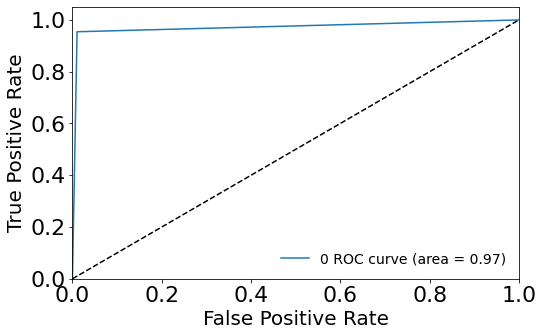

In [100]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
lb.fit(y_test)
lb.classes_.tolist()

fpr = dict()
tpr = dict()

roc_auc = dict()

by_test = lb.transform(y_test)
by_pred = lb.transform(y_pred)

print (by_test.size)
print (by_pred.size)

for i in range(lb.classes_.size):
    fpr[i], tpr[i], _ = roc_curve(by_test[:,0], by_pred[:,0])
    roc_auc[i] = auc(fpr[i], tpr[i])

#roc_auc = roc_auc_score(by_test, by_pred, average=None)
roc_auc

plt.figure(figsize=(8, 5))
for i in range(lb.classes_.size-1):
    plt.plot(fpr[i], tpr[i], 
             label='%s ROC curve (area = %0.2f)' % (lb.classes_.tolist()[i], roc_auc[i]))
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20) 
plt.tick_params(axis='both', which='major', labelsize=22)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.show()

provo linear svm su dataset completo ma per c=100 l'algoritmo non converge non potendo quindi fidarmi del risultato ottenuto. c=10 raggiunge risultato migliore sul test set, ma applico pca per riduzione dimensionalità e visualizzazione del decision boundary con diversi kernel e valori di c.

#PCA E DECISION BOUNDARY

In [0]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(X)
X_pca = pca.transform(X)

decision_function = clf.decision_function(X)
support_vector_indices = np.where((2 * y - 1) * decision_function <= 1)[0]
support_vectors = X[support_vector_indices]

In [0]:
support_vectors_pca = pca.transform(support_vectors)

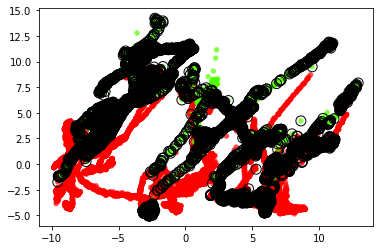

<Figure size 72000x72000 with 0 Axes>

In [103]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap=plt.cm.prism, edgecolor='none', alpha=0.7, s=30)
plt.scatter(support_vectors_pca[:, 0], support_vectors_pca[:, 1], s=100,
                linewidth=1, facecolors='none', edgecolors='k')
plt.figure(figsize=(1000,1000))
plt.show()

In [104]:
df['comp1'] = X_pca[:,0]
df['comp2'] = X_pca[:,1]


del df['Day']
del df['TimeSlot']
del df['Weekend']
del df['WorkingHour']
del df['Temperature']
del df['Humidity']
del df['Light']
del df['CO2']
del df['HumidityRatio']

print (df)

       Occupancy     comp1      comp2
0              1 -4.599620  10.770743
1              1 -4.550521  10.840133
2              1 -4.565146  10.879799
3              1 -4.649525  10.585328
4              1 -4.568006  10.668541
...          ...       ...        ...
20555          1  7.435477   2.213252
20556          1  7.501652   2.348326
20557          1  7.532142   2.436229
20558          1  7.979171   2.946772
20559          1  8.646965   4.210012

[20560 rows x 3 columns]


provo a classificare con svm lineare e cross-validation

In [105]:
attributes = [col for col in df.columns if col != class_name]
X = df[attributes].values
y = df[class_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)

clf = LinearSVC(C=10, random_state=42, max_iter=1000000)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

from sklearn.model_selection import cross_val_score

scores = cross_val_score(clf, X_train, y_train, cv=10)
print('Accuracy: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

scores = cross_val_score(clf, X_train, y_train, cv=10, scoring='f1_macro')
print('F1-score: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

Accuracy 0.8787289234760052
F1-score [0.92321905 0.71164225]
              precision    recall  f1-score   support

           0       0.90      0.95      0.92      4743
           1       0.79      0.65      0.71      1425

    accuracy                           0.88      6168
   macro avg       0.84      0.80      0.82      6168
weighted avg       0.87      0.88      0.87      6168

Accuracy: 0.8777 (+/- 0.02)
F1-score: 0.8171 (+/- 0.03)


roc curve

6168
6168


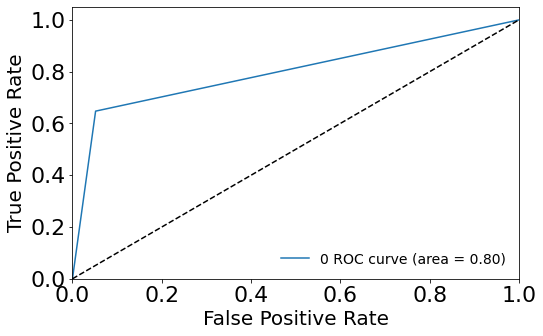

In [106]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
lb.fit(y_test)
lb.classes_.tolist()

fpr = dict()
tpr = dict()

roc_auc = dict()

by_test = lb.transform(y_test)
by_pred = lb.transform(y_pred)

print (by_test.size)
print (by_pred.size)

for i in range(lb.classes_.size):
    fpr[i], tpr[i], _ = roc_curve(by_test[:,0], by_pred[:,0])
    roc_auc[i] = auc(fpr[i], tpr[i])

#roc_auc = roc_auc_score(by_test, by_pred, average=None)
roc_auc

plt.figure(figsize=(8, 5))
for i in range(lb.classes_.size-1):
    plt.plot(fpr[i], tpr[i], 
             label='%s ROC curve (area = %0.2f)' % (lb.classes_.tolist()[i], roc_auc[i]))
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20) 
plt.tick_params(axis='both', which='major', labelsize=22)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.show()

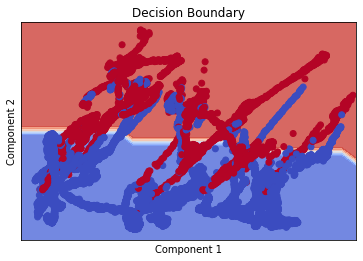

In [107]:
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.svm import LinearSVC

class_name = 'Occupancy'

attributes = [col for col in df.columns if col != class_name]
X = df[attributes].values
y = df[class_name]
y=y.astype('int')

X.shape[1]
y=y.ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max),
                     np.arange(y_min, y_max))

plt.subplot(1, 1, 1)
plt.subplots_adjust(wspace=0.4, hspace=0.4)

clf = LinearSVC(C=10, random_state=42, max_iter=1000000)

clf.fit(X_train,y_train)
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

# Plot also the training points

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())
plt.title('Decision Boundary')

plt.show()